In [2]:
import requests 
from urllib.parse import urlencode 
import pandas as pd
import numpy as np

import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from scipy.stats import mannwhitneyu
from tqdm.auto import tqdm
from scipy.stats import norm
plt.style.use('ggplot')
from scipy.stats import chi2_contingency
import datetime as dt

### Задание 1  
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

In [7]:
"""Данная функция подгружает данные (таблицу с регистрацией пользователей и временем заходом в игру),
    преобразовывает время в формат datetime, объединяет обе таблицы, подсчитывает количество дней захода в игру после
    регистрации и подсчитывает retention"""

def retention_rate(N):
    
    reg_data = pd.read_csv('~/shared/problem1-reg_data.csv', sep = ';')
    auth_data = pd.read_csv('~/shared/problem1-auth_data.csv', sep = ';')
    
    reg_data['date_reg'] = pd.to_datetime(reg_data.reg_ts, unit='s')
    auth_data['date_auth'] = pd.to_datetime(auth_data.auth_ts, unit='s')
    
    merged_data = pd.merge(reg_data, auth_data, on='uid')
    
    merged_data['days_since_reg'] = (merged_data.date_auth - merged_data.date_reg).dt.days
    
    retention_rate = merged_data[merged_data['days_since_reg'] == N].uid.nunique() / merged_data.uid.nunique()
    
    return retention_rate

In [8]:
N = 5
retention_rate(N)

0.063713

### Задание 2  
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

Считывание данных c Яндекс Диск:

In [9]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q' 
 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
download_response = requests.get(download_url) 
df = pd.read_csv(download_url, sep=';') 
df.head(5)

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


Посмотрим ARPU по группам, а также выручку и количество пользователей:

In [10]:
arpu = df.groupby('testgroup', as_index = False).agg({'revenue':'sum', 'user_id':'count'})
arpu['arpu'] = arpu.revenue / arpu.user_id
arpu

,testgroup,revenue,user_id,arpu
0,a,5136189,202103,25.413720
1,b,5421603,202667,26.751287


In [11]:
revenue_dummy = pd.get_dummies(data=df[['testgroup', 'revenue']], drop_first = True)

In [12]:
results = smf.ols('revenue ~ testgroup_b', revenue_dummy).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3896
Date:                Mon, 15 May 2023   Prob (F-statistic):              0.532
Time:                        21:39:02   Log-Likelihood:            -3.2153e+06
No. Observations:              404770   AIC:                         6.431e+06
Df Residuals:                  404768   BIC:                         6.431e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      25.4137      1.516     16.761      

ARPU тестовой группы равен 26,75, а контрольной 25,41 (соотв. исходным данным). p_value равен 0,532 > 0,05.

In [13]:
df_revenue_a = df.query('testgroup == "a"')['revenue']
df_revenue_b = df.query('testgroup == "b"')['revenue']

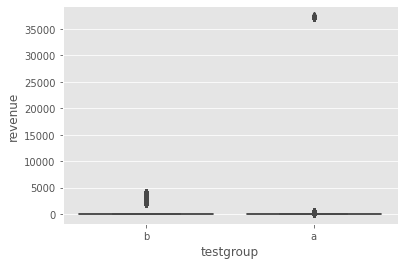

In [14]:
sns.boxplot(x="testgroup", y="revenue", data=df)

Проверка на нормальность распределений:

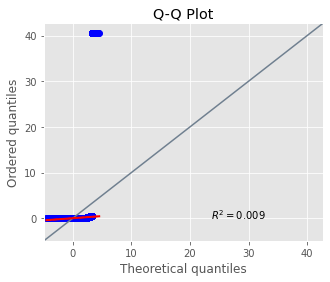

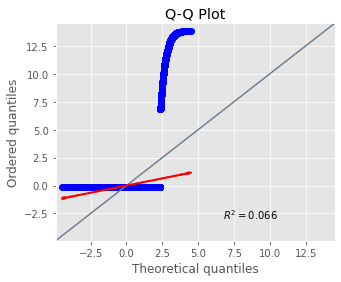

In [15]:
pg.qqplot(df_revenue_a)
pg.qqplot(df_revenue_b)

Распределения не нормальны. Проверим гомогенность дисперсий тестовой и контрольных групп:

In [16]:
ss.levene(df_revenue_a, df_revenue_b)

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

По результату p_value теста Левена значительно больше 0,05 - дисперсии гомогенны. Поскольку диспресии гомогенны, количество значений в обеих выборках велико, проведем t-тест между тестовой и контрольной группами:

In [17]:
print(ss.ttest_ind(df_revenue_b, df_revenue_a))

Ttest_indResult(statistic=0.6242026493616787, pvalue=0.532494858971837)


Значение p_value больше 0,05 - соответственно принимаем нулевую гипотезу о равенстве средних (ARPU) контрольной и тестовой группы

Посмотрим конверсию в оплату:

In [18]:
df_b = df.query('testgroup == "b"')
df_a = df.query('testgroup == "a"')

In [19]:
b_cr = df_b.query('revenue > 0')['revenue'].shape[0]
b_cr_not_premium = df_b['revenue'].shape[0]
a_cr = df_a.query('revenue > 0')['revenue'].shape[0]
a_cr_not_premium = df_a['revenue'].shape[0]
T = np.array([[b_cr, b_cr_not_premium], [a_cr, a_cr_not_premium]])
T

array([[  1805, 202667],
       [  1928, 202103]])

In [20]:
res_pvalue = ss.chi2_contingency(T)[1]
res_pvalue

0.03824373651044168

In [21]:
print(b_cr / (b_cr + b_cr_not_premium)*100)
print(a_cr / (a_cr + a_cr_not_premium)*100)

0.8827614538909974
0.9449544431973572


Получено значение p_value < 0.05. Соотв., принимаем альтернативную гипотезу, конверсии двух групп стат.значимо отличаются, причем конверсия в оплату в контрольной группе выше, чем в тестовой.

Итак, несмотря на более высокий ARPU в тестовой группе, стат.значимых отличий между группами по результату t-теста выявлено не было, в тоже время конверсия в оплату снизилась в тестовой группе. Можно сказать о нецелосообразности раскатывания новой версии акционных предложений на всех пользователей.